# <center>利用snap构建基于随机游走的推荐系统</center >  
Snap是基于Python的一个复杂网络的开源工具包,本片参考论文 Pixie: A System for Recommending 3+ Billion Items to 200+ Million Users in Real-Time,本篇使用Snap并结合Movielens数据集构建电影推荐系统.




# Python2.7

# 目录  

[snap文档](#0)  
[数据集介绍](#1)  
[导入数据](#2)  
[建立二分图](#3)  
[使用随机游走进行推荐](#4)  
[随机游走参数分析](#5)  
[加权网络推荐](#6)

<a id='0'></a>
# <div> snap 文档</div>
<div>[learn SNAP (http://snap.stanford.edu/)](http://snap.stanford.edu/)  </div>
<div>[Install instruction (http://snap.stanford.edu/proj/snap-www/SNAP-WWW15-part2.pdf)](http://snap.stanford.edu/proj/snap-www/SNAP-WWW15-part2.pdf)  </div>
<div>[Reading (mandatory): http://snap.stanford.edu/proj/snap-www/SNAP-WWW15-part2.pdf](http://snap.stanford.edu/proj/snap-www/SNAP-WWW15-part2.pdf) </div>
<div>[详细文档 (http://snap.stanford.edu/snap/doc/snapuser-ref/classes.html)](http://snap.stanford.edu/snap/doc/snapuser-ref/classes.html)  </div>

<a id='1'></a>
# 数据集介绍
Movielens数据集(https://grouplens.org/datasets/movielens/) 涵盖了用户对不同电影的评价,以及各电影的标签,IMDB ID等.  
本次实验主要使用数据集中的ratings表,表如下:  
userId:用户id  
movieId:电影id  
ratings:用户评级  
timestamp:用户评级时间戳  


In [28]:
# 加载数据分析常用库
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import json
import snap
from IPython.display import Image
import matplotlib.image as mpimg
from IPython.display import display
import time
import random
import math
%matplotlib inline

#关闭警告信息
import warnings
warnings.filterwarnings('ignore')

##设置最大显示的行数和列数
pd.set_option('display.max_columns',10)
pd.set_option('display.max_rows',10)

<a id='2'></a>
# 导入数据

In [29]:
#读取数据

df_ratings = pd.read_csv('C:\Users\smxbe\DataMining\Movielen\ml-latest-small/ratings.csv')


In [30]:

n_users = df_ratings.userId.unique().shape[0]
n_items = df_ratings.movieId.unique().shape[0]
print(str(n_users) + ' users')
print(str(n_items) + ' movies')

671 users
9066 movies


# 对movieId做映射

In [31]:
movie_map = df_ratings[['movieId']].drop_duplicates().reset_index()
MAPID = pd.DataFrame(np.arange(1,n_items+1).reshape(n_items,1),columns=['mapid'])
movie_map['mapid'] = MAPID['mapid']
movie_map.drop('index',axis=1, inplace=True)
df_ratings = pd.merge(df_ratings,movie_map, on = ['movieId'],how = 'left')
df_ratings['mapid']=df_ratings['mapid'].astype(int)
print(df_ratings.shape)
df_ratings.head(5)

(100004, 5)


,userId,movieId,rating,timestamp,mapid
0,1,31,2.5,1260759144,1
1,1,1029,3.0,1260759179,2
2,1,1061,3.0,1260759182,3
3,1,1129,2.0,1260759185,4
4,1,1172,4.0,1260759205,5


<a id='3'></a>
# 建立二分图

什么是图，如图所示，X节点表示用户，Y节点表示商品，连线表示用户购买了商品
![image description](https://timgsa.baidu.com/timg?image&quality=80&size=b9999_10000&sec=1519640422699&di=776b7b976f390246ed2b1bca9737aae6&imgtype=0&src=http%3A%2F%2Fimages.cnitblog.com%2Fblog%2F646072%2F201411%2F061225356117547.png)
<div> 通过图的推荐最简单的栗子：</div>
<div> 用户Jack购买了商品A,B</div>
<div>用户Peter购买了商品B,C,D</div>
<div>两者都购买了B，我们就向Jack推荐C,D，向Peter推荐A</div>
<div>以下实验使用 SNAP 包完成</div>

<div>userId和movieId存在相同的情况，snap中的图的结点只能存放整数，因此我们将movieId全部加上1000避免重复</div>
<div>同时取出userid，moveid保存到txt，用空格分隔</div>

In [32]:
#ratings = df_ratings[['userId','movieId']]
ratings = df_ratings
ratings['mapid'] = ratings['mapid'].apply(lambda x: x+1000)

#抽取训练样本,并保存为txt
train_ratings = ratings.sample(frac= 0.8)


train_ratings.to_csv('train.txt',index = False,sep=' ')
ratings.head(5)

,userId,movieId,rating,timestamp,mapid
0,1,31,2.5,1260759144,1001
1,1,1029,3.0,1260759179,1002
2,1,1061,3.0,1260759182,1003
3,1,1129,2.0,1260759185,1004
4,1,1172,4.0,1260759205,1005


使用snap读取txt保存到有向图

In [33]:
g_ratings = snap.LoadEdgeList(snap.PNGraph,"train.txt",0,4)

# 绘制出入度分布图（可用gnuplot代替更方便）


In [5]:
def plotDegDistr(Graph,type='in'):
    DegToCntV = snap.TIntPrV()
    if(type=='in'): 
        snap.GetInDegCnt(Graph, DegToCntV)
    else:
        snap.GetOutDegCnt(Graph,DegToCntV)
    x=[]
    y=[]
    for item in DegToCntV:
        x.append(item.GetVal1())
        y.append(item.GetVal2())
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(type+"-degree")
    plt.ylabel('count')
    plt.grid(True)
    plt.plot(x,y,'m.-')

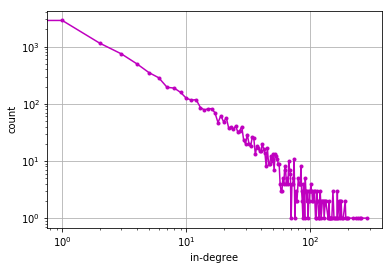

In [8]:
#入度
plotDegDistr(g_ratings,'in')

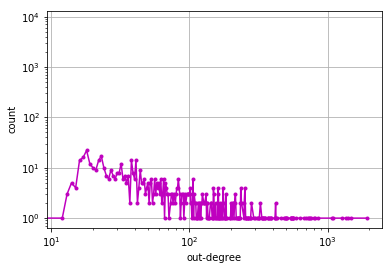

In [9]:
#出度
plotDegDistr(g_ratings,'out')

输出图的基本信息 

In [10]:
snap.PrintInfo(g_ratings, "Ratings",'ratings graph info.txt',False)
all_the_text = open('ratings graph info.txt').read()
print all_the_text

Ratings: Directed
  Nodes:                    9026
  Edges:                    80003
  Zero Deg Nodes:           0
  Zero InDeg Nodes:         671
  Zero OutDeg Nodes:        8355
  NonZero In-Out Deg Nodes: 0
  Unique directed edges:    80003
  Unique undirected edges:  80003
  Self Edges:               0
  BiDir Edges:              0
  Closed triangles:         0
  Open triangles:           18236565
  Frac. of closed triads:   0.000000
  Connected component size: 1.000000
  Strong conn. comp. size:  0.000111
  Approx. full diameter:    6
  90% effective diameter:  3.837432



<a id='4'></a>
# 基于随机游走的 Walk Random 的推荐算法

根据论文中的算法1我们构建了基于随机游走推荐系统  
https://arxiv.org/pdf/1711.07601.pdf  
随机游走的核心思想是从给定的结点出发,根据步长不断随机访问与当前结点相连的结点,并统计各个结点的访问次数,最初推荐访问次数最多的top_k个结点
随机游走的整体时间消耗与给定的 总步数 N 成正比

一 Given a user, recommend top K items.

In [24]:
def user_topk_item(input_graph,a,N,input_userid,top_k):
    # a determines the length of walks
    # N is the total number of steps of the walk
    # top_k means how many movies will the system recommend
    total_steps = 0
    if g_ratings.IsNode(input_userid)==False:
        print('user  %d  does not rate please input anothor userid' %userid)
    #create a vector to store node visit counts
    node_count = np.zeros(input_graph.GetMxNId())
    while  total_steps <= N :
        cur_steps = random.randint(1,a)
        cur_user=input_graph.GetNI(input_userid)
        for i in range(0,cur_steps): 
            itemid = cur_user.GetOutNId(random.randint(0,cur_user.GetOutDeg()-1))
            cur_item = input_graph.GetNI(itemid)
            userid  = cur_item.GetInNId(random.randint(0,cur_item.GetInDeg()-1))
            cur_user=input_graph.GetNI(userid)
            node_count[itemid-1] += 1
        total_steps += cur_steps
    recommend = pd.DataFrame({'mapid':np.arange(1,g_ratings.GetMxNId()+1),'visits':node_count})
    recommend = recommend.sort_values(by = 'visits',axis = 0,ascending = False)[0:top_k]
    return recommend
        

In [37]:
def cal_recall(input_recommend,input_userid):
    recommend = input_recommend
    user_actual = ratings[ratings.userId.values == input_userid]
    user_actual = pd.merge(user_actual,recommend,on=['mapid'],how = 'left')
    user_actual['ifvisit'] = user_actual.visits.apply(lambda x:1 if x>0  else 0)
    recommend_true = float(user_actual.ifvisit.sum())
    user_visit_sum  = float(user_actual.shape[0])
    recall = recommend_true / user_visit_sum 
    return recall

def cal_precision(input_recommend,input_userid):
    recommend = input_recommend
    user_actual = ratings[ratings.userId.values == input_userid]
    user_precise = pd.merge(recommend,user_actual,on=['mapid'],how = 'left')
    user_precise['ifvisit'] = user_precise.rating.apply(lambda x:1 if x>0  else 0)
    recommend_true = float(user_precise.ifvisit.sum())
    user_visit_sum  = float(user_precise.shape[0])
    recall = recommend_true / user_visit_sum 
    return recall
    
    

In [35]:
test_userid  = 1
result = user_topk_item(g_ratings,3,10000,test_userid,25)
recall = cal_recall(result,test_userid)
print 'the recall of user %d is %f' %(test_userid,recall)
print 'recommend movies is below'
result.head()


the recall of user 1 is 0.800000
recommend movies is below


,mapid,visits
1011,1012,357.0
1019,1020,345.0
1000,1001,336.0
1012,1013,331.0
1004,1005,330.0


In [39]:
precision = cal_precision(result,test_userid)
print 'precision is below'
precision

precision is below


0.64

In [40]:
%%timeit
time_test = user_topk_item(g_ratings ,3,10000,test_userid,25)

10 loops, best of 3: 70.3 ms per loop


接下来测试总体的平均recall

In [41]:
recall_list = []
for i in range(1,1001):
    userid = i
    if  g_ratings.IsNode(userid):
        recommend = user_topk_item(g_ratings ,6,10000,userid,25)
        recall_list.append(cal_recall(recommend,userid))
np.mean(recall_list)

0.40571119493262325

## 一 Given a user, recommend top K users.

In [46]:
def user_topk_user(input_graph,a,N,input_userid,top_k):
    # a determines the length of walks
    # N is the total number of steps of the walk
    # top_k means how many users will the system recommend
    total_steps = 0
    if g_ratings.IsNode(input_userid)==False:
        print('user  %d  does not rate please input anothor userid' %userid)
    node_count = np.zeros(input_graph.GetMxNId())     #create a vector to store node visit counts
    while  total_steps <= N :
        cur_steps = random.randint(0,a) #get step length
        cur_user=input_graph.GetNI(input_userid) #get user node
        for i in range(0,cur_steps):
            itemid = cur_user.GetOutNId(random.randint(0,cur_user.GetOutDeg()-1)) #get item node id
            #print 'itemid %d' %itemid
            cur_item = input_graph.GetNI(itemid) #get item node
            userid  = cur_item.GetInNId(random.randint(0,cur_item.GetInDeg()-1))
            #print 'userid %d' %userid
            cur_user=input_graph.GetNI(userid)
            node_count[userid-1] += 1 # add the visit counts of node 
        total_steps += cur_steps
    recommend = pd.DataFrame({'userId':np.arange(1,g_ratings.GetMxNId()+1),'visits':node_count})
    recommend = recommend.sort_values(by = 'visits',axis = 0,ascending = False)[0:top_k]
    return recommend

In [47]:
#test
test_userid = 1 
result = user_topk_user(g_ratings ,5,10000,test_userid,25)
print 'recommend user lists is below'
result.head()

recommend user lists is below


,userId,visits
72,73,219.0
546,547,181.0
467,468,163.0
563,564,163.0
14,15,160.0


## 一 Given a item recommend top K items.

In [48]:
def item_topk_item(input_graph,a,N,input_itemid,top_k):
    # a determines the length of walks
    # N is the total number of steps of the walk
    # top_k means how many users will the system recommend
    total_steps = 0
    if g_ratings.IsNode(input_itemid)==False:
        print('no one watches movie %d  please input anothor movieid' %itemid)
    #create a vector to store node visit counts
    node_count = np.zeros(input_graph.GetMxNId())
    while  total_steps <= N :
        cur_steps = random.randint(0,a)
        cur_item=input_graph.GetNI(input_itemid)
        for i in range(0,cur_steps):
            userid  = cur_item.GetInNId(random.randint(0,cur_item.GetInDeg()-1))
            #print 'userid %d' %userid
            cur_user=input_graph.GetNI(userid)
            itemid = cur_user.GetOutNId(random.randint(0,cur_user.GetOutDeg()-1))
            #print 'itemid %d' %itemid
            cur_item = input_graph.GetNI(itemid)
            node_count[itemid-1] += 1
        total_steps += cur_steps
    recommend = pd.DataFrame({'itemId':np.arange(1,g_ratings.GetMxNId()+1),'visits':node_count})
    recommend = recommend.sort_values(by = 'visits',axis = 0,ascending = False)[0:top_k]
    return recommend

In [49]:
#test
itemid  = 1001
result = item_topk_item(g_ratings ,5,10000,itemid,25)
print 'movies similar with movie %d is below' %itemid
result.head()

movies similar with movie 1001 is below


,itemId,visits
1000,1001,70.0
1088,1089,50.0
1099,1100,49.0
1092,1093,49.0
1027,1028,46.0


<a id='5'></a>
# 参数分析

<div>在基于图的推荐中,参数a决定了每次随机游走,结点所覆盖的广度,暂时推断a越大,覆盖的节点一搬会更多</div>
<div>接下来我们看一下在Given a user, recommend top K items中,取不同大小的a,对最终的总体recall有什么影响</div>

In [52]:
a_list = []
all_recall_list = []
all_precision_list = []
for a in range(1,21):
    a_list.append(a)
    recall_list = []
    precision_list =[]
    for i in range(1,1001):
        userid = i
        if  g_ratings.IsNode(userid):
            recommend = user_topk_item(g_ratings ,a,10000,userid,25)
            recall_list.append(cal_recall(recommend,userid))
            precision_list.append(cal_precision(recommend,userid))
    all_recall_list.append(np.mean(recall_list))
    all_precision_list.append(np.mean(precision_list))

Text(0,0.5,u'Y values for precision')

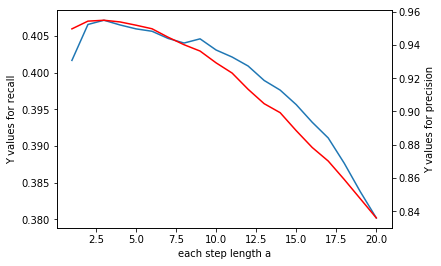

In [53]:


fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(a_list, all_recall_list)
ax1.set_ylabel('Y values for recall')
ax1.set_xlabel("each step length a")

ax2 = ax1.twinx()  # this is the important function
ax2.plot(a_list, all_precision_list, 'r')
ax2.set_ylabel('Y values for precision')

如图所示我们发现,随着a的不断增大,recall和precision会不断减小，所以这里a设为2左右比较好

# 推荐不同top_k部电影时的recall和precision比较

In [54]:
topk_list = []
all_recall_list = []
all_precision_list = []
for top_k in range(5,100,5):
    topk_list.append(top_k)
    recall_list = []
    precision_list = []
    for i in range(1,1001):
        userid = i
        if  g_ratings.IsNode(userid):
            recommend = user_topk_item(g_ratings ,5,10000,userid,top_k)
            recall_list.append(cal_recall(recommend,userid))
            precision_list.append(cal_precision(recommend,userid))
    all_recall_list.append(np.mean(recall_list))
    all_precision_list.append(np.mean(precision_list))

Text(0,0.5,u'Y values for precision')

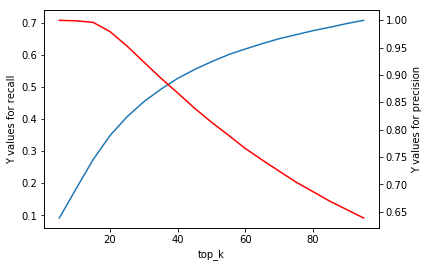

In [55]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(topk_list, all_recall_list)
ax1.set_ylabel('Y values for recall')
ax1.set_xlabel("top_k")

ax2 = ax1.twinx()  # this is the important function
ax2.plot(topk_list, all_precision_list, 'r')
ax2.set_ylabel('Y values for precision')


我们发现,recall 和precision 两条线在top_k = 40的时候相交,因此我们将topk_设为40 是比较折中的

# <a id='6'></a>
# 使用加权的图进行推荐

<div>由于每个用户对不同电影的评分不同,因此在随机游走的时候我们认为评价更高的边具有更高的权重,更容易成为游走的路径</div>
<div>同时,我们推测,在加入权重的影响因素后,可以降低在 a 过大 时导致随机游走过于偏远而引起的 recall快速下降的问题</div>
<div>在不考虑权重的情况下,更类似与广度搜索,在考虑权重的情况下,更类似于深度搜索</div>

In [56]:
net_ratings = snap.TNEANet.New()  #生成一个新的网络图,可以存放边的信息
net_ratings.AddFltAttrE('rating') #为网络图的边增加一个叫 rating 的属性

0

In [66]:
#为网络图生成用户和电影的结点
#为网络图添加用户和电影的边,并给每条边添加对应的评级信息
for row in train_ratings.itertuples():
    userid =row[1]
    movieid = row[5]
    rating = row[3]
    if net_ratings.IsNode(userid)==False:
        net_ratings.AddNode(userid)
    if net_ratings.IsNode(movieid)==False:
        net_ratings.AddNode(movieid)
    edgeid = net_ratings.AddEdge(userid,  movieid)
    net_ratings.AddFltAttrDatE(edgeid,rating,'rating')

In [67]:
#输出网络图的信息
snap.PrintInfo(net_ratings, "Ratings",'ratings net info.txt',False)
all_the_text = open('ratings net info.txt').read()
print all_the_text

Ratings: Directed Multigraph
  Nodes:                    12530
  Edges:                    160006
  Zero Deg Nodes:           0
  Zero InDeg Nodes:         103
  Zero OutDeg Nodes:        11859
  NonZero In-Out Deg Nodes: 568
  Unique directed edges:    155536
  Unique undirected edges:  155191
  Self Edges:               23
  BiDir Edges:              713
  Closed triangles:         6192
  Open triangles:           73344691
  Frac. of closed triads:   0.000084
  Connected component size: 1.000000
  Strong conn. comp. size:  0.043496
  Approx. full diameter:    5
  90% effective diameter:  3.615664



In [68]:
#保存网络图
FOut = snap.TFOut("net_ratings.graph")
net_ratings.Save(FOut)
FOut.Flush()


In [69]:
#读取网络图
FIn = snap.TFIn("net_ratings.graph") 
net_ratings = snap.TNEANet.Load(FIn) 
    


In [70]:
def weighted_user_topk_item(input_graph,a,N,input_userid,top_k):
    # a determines the length of walks
    # N is the total number of steps of the walk
    # top_k means how many movies will the system recommend
    
    def weighted_random_walk(node,in_out): #根据权重选择路径,返回的值为选择第几条路径
        walk_area = 0
        which_way = 0
        if in_out == 'out':
            for j in range(0,node.GetOutDeg()):
                edgeid = input_graph.GetEI(node.GetId(),node.GetOutNId(j))
                walk_area += input_graph.GetFltAttrDatE(edgeid, 'rating')
            p = random.randint(0,math.floor(walk_area))
            for q in range(0,node.GetOutDeg()-1):
                edgeid = input_graph.GetEI(node.GetId(),node.GetOutNId(q))
                p = p - input_graph.GetFltAttrDatE(edgeid, 'rating')
                if p<=0:
                    which_way = q
                    break

        else:
            for j in range(0,node.GetInDeg()):
                edgeid = input_graph.GetEI(node.GetInNId(j),node.GetId())
                walk_area += input_graph.GetFltAttrDatE(edgeid, 'rating')
            p = random.randint(0,math.floor(walk_area))
            for q in range(0,node.GetInDeg()-1):
                edgeid = input_graph.GetEI(node.GetInNId(q),node.GetId())
                p = p - input_graph.GetFltAttrDatE(edgeid, 'rating')
                if p<= 0:
                    which_way = q
                    break
        return which_way


    total_steps = 0
    if input_graph.IsNode(input_userid)==False:
        print('user  %d  does not rate please input anothor userid' %input_userid)
    #create a vector to store node visit counts
    node_count = np.zeros(input_graph.GetMxNId())
    while  total_steps <= N :
        cur_steps = random.randint(1,a)
        cur_user=input_graph.GetNI(input_userid)
        for i in range(0,cur_steps): 
            itemid = cur_user.GetOutNId(weighted_random_walk(cur_user,'out'))
            #print 'itemid %d' %itemid
            cur_item = input_graph.GetNI(itemid)
            userid  = cur_item.GetInNId(weighted_random_walk(cur_item,'in'))
            #print 'userid %d' %userid
            cur_user=input_graph.GetNI(userid)
            node_count[itemid-1] += 1
        total_steps += cur_steps
    recommend = pd.DataFrame({'mapid':np.arange(1,net_ratings.GetMxNId()+1),'visits':node_count})
    recommend = recommend.sort_values( by = 'visits',axis = 0,ascending = False)[0:top_k]
    return recommend

In [71]:
test_userid = 1
aaa = weighted_user_topk_item(net_ratings,6,1000,test_userid,25)
recall = cal_recall(aaa,test_userid)
print 'the recall of user %d is %f' %(test_userid,recall)
print 'recommend movies is below'
aaa.head()


the recall of user 1 is 0.650000
recommend movies is below


,mapid,visits
3670,3671,21.0
1012,1013,20.0
1171,1172,20.0
2293,2294,18.0
1952,1953,17.0


在加权的随机游走上面,按权重选择路径的算法的过于复杂,导致时间增加了很多,应该有更好的方法按权重选择路径.
从测试用户 1来看, 加权的随机游走 recall为 比非加权的性能要好